# Tutorial

https://www.kaggle.com/code/frankmollard/a-story-about-unsupervised-learning

# Import


In [45]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import torch
from torch import nn

from tqdm import tqdm
from collections import defaultdict

#  EDA Wine Dataset UCI
https://archive.ics.uci.edu/dataset/186/wine+quality

In [ ]:
ROOT = os.getcwd()
RED_WINE_DATASET = os.path.join(ROOT, 'dataset', 'wine+quality', 'winequality-red.csv')
WHITE_WINE_DATASET = os.path.join(ROOT, 'dataset', 'wine+quality', 'winequality-white.csv')
assert os.path.exists(RED_WINE_DATASET), 'path to red wine dataset not found'
assert os.path.exists(WHITE_WINE_DATASET), 'path to white wine dataset not found'

In [ ]:
df = pd.read_csv(RED_WINE_DATASET, delimiter=';')
print(df.shape)
print('columns = ', list(df.columns))
df.head()

In [ ]:
df.describe()

# Normalize

use mean and std normalization

In [ ]:
newdf = df.drop('quality', axis = 1).copy()

for c in newdf.columns:
    newdf[c] = (newdf[c] - newdf[c].mean())/(newdf[c].std())

newdf.describe()

In [ ]:
target = df['quality']
print('target = ', target.shape)
unique_quality_values = set(target.unique())
print(unique_quality_values)

# Anomaly Detection Methods

### PCA

(1599, 2)


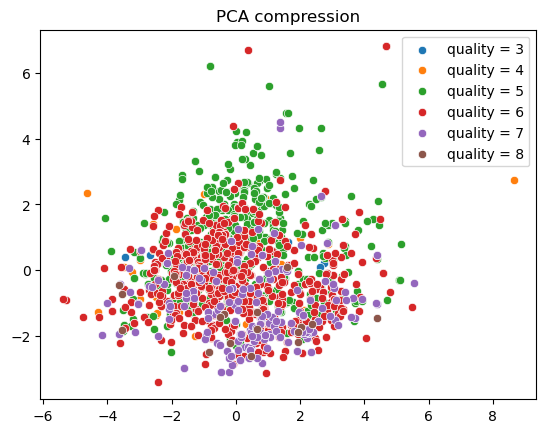

In [77]:
pca = PCA(
    n_components=2
)

compressed = pca.fit_transform(newdf)
print(compressed.shape)

for quality in unique_quality_values:
    data = y = compressed[target == quality]
    sns.scatterplot(x = data[:,0], y= data[:,1], label = f'quality = {quality}')

plt.title('PCA compression')
plt.show()

### TSNE

compressed shape =  (1599, 2)


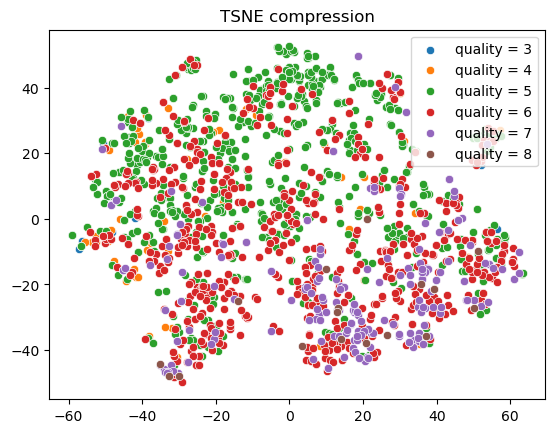

In [81]:
tsne = TSNE(
    n_components=2
)

compressed = tsne.fit_transform(newdf)
print('compressed shape = ', compressed.shape)

for quality in unique_quality_values:
    data = y = compressed[target == quality]
    sns.scatterplot(x = data[:,0], y= data[:,1], label = f'quality = {quality}')

plt.title('TSNE compression')
plt.show()

### Autoencoder

In [96]:
class AutoEncoder(nn.Module):

    def __init__(self, input_size, embedding_size = 2) -> None:
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.BatchNorm1d(32),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.BatchNorm1d(16),
            nn.Linear(16, embedding_size)
        ) 

        self.decoder = nn.Sequential(
            nn.Linear(embedding_size, 16),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.BatchNorm1d(16),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.BatchNorm1d(32),
            nn.Linear(32, input_size)
        ) 

    
    def forward(self, X):
        embedded = self.encoder(X)
        return self.decoder(embedded)
    
class Trainer:
    def __init__(self, model: nn.Module, optimizer_fn, criterion_fn, lr = 0.001, epochs = 1000) -> None:
        self.model = model
        self.epochs = epochs
        self.lr = lr

        self.optimizer = optimizer_fn(self.model.parameters(), lr = lr)
        self.criterion = criterion_fn()
        self.history = defaultdict(list)

    def optimize(self, input, target):
        self.optimizer.zero_grad()
        loss = self.criterion(input, target)
        loss.backward()
        self.optimizer.step()

    def train(self, X_train, X_valid = None):
        self.model.train()
        self.history.clear()

        assert torch.is_tensor(X_train), 'X train must be tensor'

        loop = tqdm(range(self.epochs))
        val_loss = None

        for e in loop:
            X_pred = self.model(X_train)
            
            loss = self.criterion(X_pred, X_train)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            self.history['train loss'].append(loss.item())
            if X_valid != None:
                val_loss = self.evaluate(X_valid)
                self.history['valid loss'].append(val_loss.item())
            
            loop.set_description(f'train loss = {loss.item():.3f}')
        
        self.plot(self.history)
        
    def evaluate(self, X_valid):
        self.model.eval()
        with torch.no_grad():
            X_valid_pred = self.model(X_valid)
            val_loss = self.criterion(X_valid_pred, X_valid)
        self.model.train()

        return val_loss
    
    def plot(self, history):        
        indices = list(range(len(history['train loss'])))
        sns.lineplot(y = history['train loss'], x =indices, label = 'train')
        if len(history['valid loss']) > 0:
            sns.lineplot(y = history['valid loss'], x =indices, label = 'valid')
        plt.title("Loss")
        plt.show()


In [97]:
sampleX = torch.rand(10, 11)
ae = AutoEncoder(sampleX.shape[-1], 2)
y = ae(sampleX)
print(y.shape)

torch.Size([10, 11])


torch.Size([1599, 11])


train loss = 0.430: 100%|██████████| 3000/3000 [00:26<00:00, 114.00it/s]


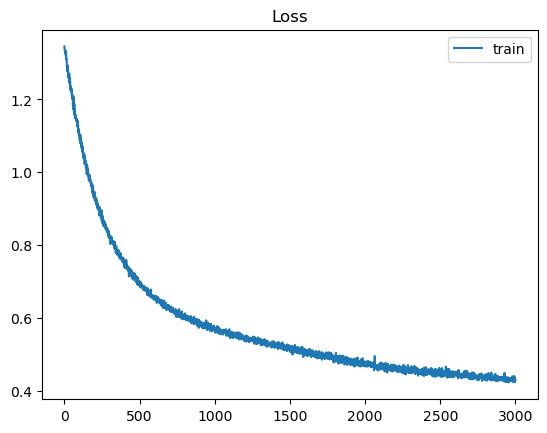

In [98]:
X_train = newdf.to_numpy()

X_train = torch.tensor(X_train).float()
print(X_train.shape)

input_size = X_train.shape[-1]
embedding_size = 2 
lr = 1e-4

autoencoder = AutoEncoder(input_size, embedding_size = embedding_size)

trainer = Trainer(
    autoencoder, 
    optimizer_fn= torch.optim.Adam, 
    criterion_fn=nn.MSELoss,
    lr = lr,
    epochs = 3000
    )

trainer.train(X_train)


(1599, 2)


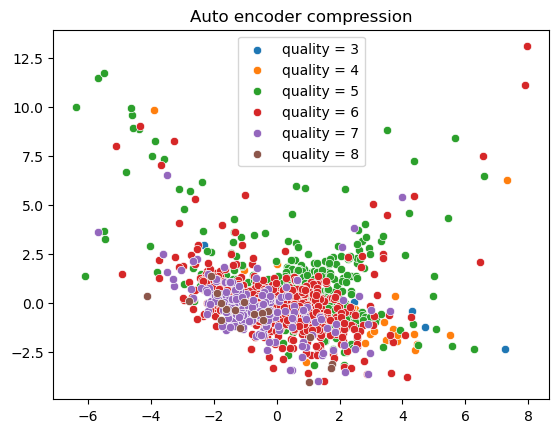

In [111]:
X_compressed = autoencoder.encoder(X_train)
X_compressed = X_compressed.detach().cpu().numpy()
print(X_compressed.shape)

for quality in unique_quality_values:
    data = X_compressed[target == quality]
    sns.scatterplot(y = data[:, 0], x = data[:,1], label = f'quality = {quality}')

plt.title('Auto encoder compression')
plt.show()